### Bagging

Este notebook apresenta uma estratégia muito natural para construir conjuntos de modelos de aprendizado de máquina chamados "bagging".

"Bagging" significa Bootstrap AGGregatING. Ele usa reamostragem bootstrap (amostragem aleatória com substituição) para aprender vários modelos em variações aleatórias do conjunto de treinamento. No momento da previsão, as previsões de cada aluno são agregadas para fornecer as previsões finais.

Primeiro, geraremos um conjunto de dados sintético simples para obter insights sobre bootstraping.

In [1]:
import pandas as pd
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

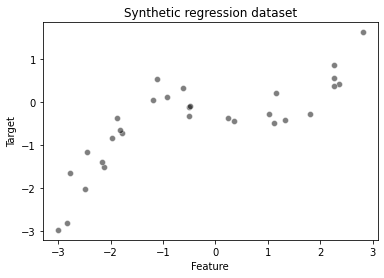

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

A relação entre nosso recurso e o alvo a ser previsto não é linear. No entanto, uma árvore de decisão é capaz de aproximar essa dependência não linear:

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

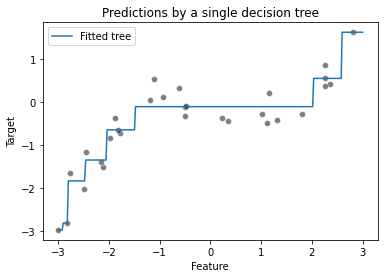

In [4]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test, y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

Vamos ver como podemos usar o bootstraping para aprender várias árvores.

### Reamostragem de bootstrap

Uma amostra de bootstrap corresponde a uma reamostragem com substituição, do conjunto de dados original, uma amostra que tem o mesmo tamanho do conjunto de dados original. Assim, a amostra de bootstrap conterá alguns pontos de dados várias vezes, enquanto alguns dos pontos de dados originais não estarão presentes.

Criaremos uma função que dados dados e destino retornará uma variação reamostrada data_bootstrap e target_bootstrap.

In [5]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

Iremos gerar 3 amostras de bootstrap e verificar qualitativamente a diferença com o conjunto de dados original.

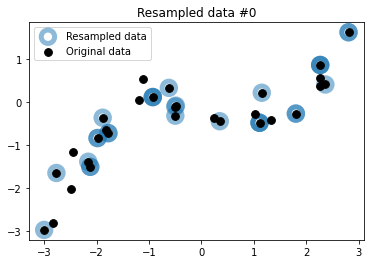

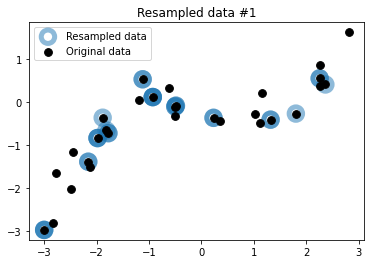

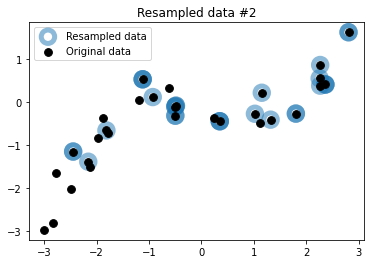

In [6]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_booststrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_booststrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

Observe que todas as 3 variações compartilham pontos comuns com o conjunto de dados original. Alguns dos pontos são reamostrados aleatoriamente várias vezes e aparecem como círculos azuis mais escuros.

As 3 amostras de bootstrap geradas são todas diferentes do conjunto de dados original e umas das outras. Para confirmar essa intuição, podemos verificar o número de amostras exclusivas nas amostras de bootstrap.

In [7]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


Em média, ~ 63,2% dos pontos de dados originais do conjunto de dados original estarão presentes em uma determinada amostra de bootstrap. Os outros ~ 36,8% são amostras repetidas.

Somos capazes de gerar muitos conjuntos de dados, todos ligeiramente diferentes.

Agora, podemos ajustar uma árvore de decisão para cada um desses conjuntos de dados e todos eles também serão ligeiramente diferentes.

In [8]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

Agora que criamos um pacote de árvores diferentes, podemos usar cada uma das árvores para prever os dados de teste. Eles devem dar previsões ligeiramente diferentes.

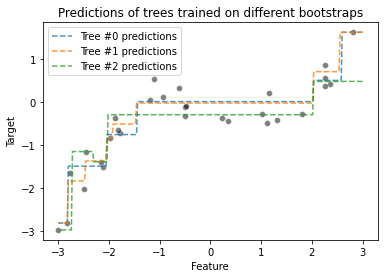

In [9]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

### Aggregating

Assim que nossas árvores estiverem ajustadas e pudermos obter previsões para cada uma delas. Na regressão, a maneira mais direta de combinar essas previsões é apenas calculá-las: para um determinado ponto de dados de teste, alimentamos os valores de recursos de entrada para cada um dos n modelos treinados no conjunto e, como resultado, calculamos n valores previstos para o variável de destino. A previsão final do conjunto para o ponto de dados de teste é a média desses n valores.

Podemos representar graficamente as previsões médias do exemplo anterior.

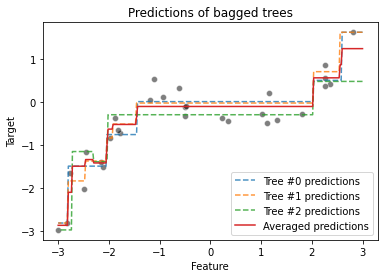

In [10]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test, bag_predictions, label="Averaged predictions",
         linestyle="-")
plt.legend()
_ = plt.title("Predictions of bagged trees")

A linha vermelha contínua mostra as previsões médias, que seriam as previsões finais fornecidas por nossa 'bolsa' de regressores de árvore de decisão. Observe que as previsões do conjunto são mais estáveis por causa da operação de cálculo da média. Como resultado, o pacote de árvores como um todo tem menos probabilidade de se ajustar demais do que as árvores individuais.

### Bagging no scikit-learn

O Scikit-learn implementa o procedimento de bagging como um "metaestimador", ou seja, um estimador que envolve outro estimador: ele pega um modelo básico que é clonado várias vezes e treinado independentemente em cada amostra de bootstrap.

O fragmento de código a seguir mostra como construir um conjunto de árvores de decisão. Definimos `n_estimators = 100` em vez de 3 em nossa implementação manual acima para obter um efeito de suavização mais forte.

In [11]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

Vamos visualizar as previsões do conjunto nos mesmos dados de teste:

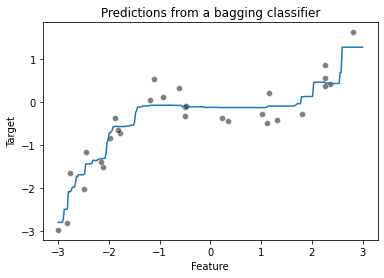

In [12]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

Como usamos 100 árvores no conjunto, a previsão média é de fato um pouco mais suave, mas muito semelhante ao nosso gráfico médio anterior.

É possível acessar os modelos internos do conjunto armazenados como uma lista Python no atributo `bagged_trees.estimators_` após o ajuste.

Vamos comparar as previsões do modelo baseado com sua média:

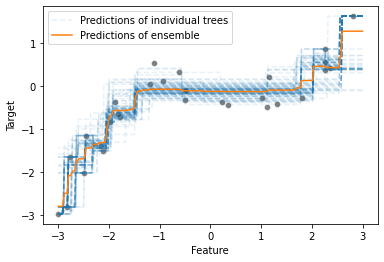

In [13]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test, bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

Usamos um valor baixo do parâmetro de opacidade alfa para avaliar melhor a sobreposição nas funções de previsão das árvores individuais.

Esta visualização fornece alguns insights sobre a incerteza nas previsões em diferentes áreas do espaço de recursos.

### Bagging complex pipelines

Embora usemos uma árvore de decisão como modelo base, nada nos impede de usar qualquer outro tipo de modelo.

Como sabemos que a função de geração de dados original é uma transformação polinomial ruidosa da variável de entrada, vamos tentar ajustar um pipeline de regressão polinomial ensacado neste conjunto de dados:

In [14]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

Este pipeline primeiro dimensiona os dados para o intervalo 0-1 com `MinMaxScaler`. Em seguida, ele extrai recursos polinomiais de grau 4. Os recursos resultantes ficarão todos na faixa 0-1 por construção: se x estiver na faixa 0-1, então x ** n também estará na faixa 0-1 para qualquer valor de n.

Em seguida, o pipeline alimenta os recursos não lineares resultantes para um modelo de regressão linear regularizado para a previsão final da variável de destino.

Observe que usamos intencionalmente um pequeno valor para o parâmetro de regularização `alfa`, pois esperamos que o conjunto de ensacamento funcione bem com modelos básicos um pouco excessivamente ajustados.

O conjunto em si é simplesmente construído passando o pipeline resultante como o parâmetro `base_estimator` da classe `BaggingRegressor`:

In [15]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

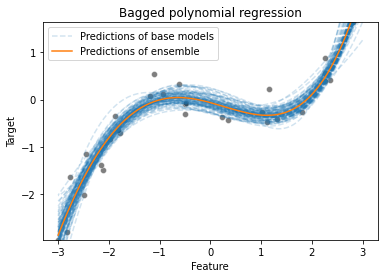

In [16]:
for i, regressor in enumerate(bagging.estimators_):
    regressor_predictions = regressor.predict(data_test)
    base_model_line = plt.plot(
        data_test, regressor_predictions, linestyle="--", alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue")

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
bagging_predictions = bagging.predict(data_test)
plt.plot(data_test, bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")

As previsões desse modelo de regressão polinomial ensacado parecem qualitativamente melhores do que as árvores ensacadas. Isso é um tanto esperado, uma vez que o modelo básico reflete melhor nosso conhecimento do verdadeiro processo de geração de dados.

Novamente, os diferentes tons induzidos pelas linhas azuis sobrepostas nos permitem avaliar a incerteza na previsão do conjunto ensacado.

Para concluir este notebook, observamos que o procedimento de bootstrapping é uma ferramenta genérica de estatística e não se limita a construir conjuntos de modelos de aprendizado de máquina. O leitor interessado pode aprender mais no artigo da [`Wikipedia sobre bootstrapping)`](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)

### 📝 Exercício M6.01

O objetivo deste caderno é investigar se podemos ajustar os hiperparâmetros de um regressor de bagging e avaliar o ganho obtido.

Vamos carregar o conjunto de dados de habitação da Califórnia e dividi-lo em um conjunto de treinamento e teste.

In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

Crie um BaggingRegressor e forneça um DecisionTreeRegressor para seu parâmetro base_estimator. Treine o regressor e avalie seu desempenho de generalização no conjunto de teste usando o erro absoluto médio.

In [24]:
# solution
for param in bagging.get_params().keys():
    print(param)

base_estimator__memory
base_estimator__steps
base_estimator__verbose
base_estimator__minmaxscaler
base_estimator__polynomialfeatures
base_estimator__ridge
base_estimator__minmaxscaler__copy
base_estimator__minmaxscaler__feature_range
base_estimator__polynomialfeatures__degree
base_estimator__polynomialfeatures__include_bias
base_estimator__polynomialfeatures__interaction_only
base_estimator__polynomialfeatures__order
base_estimator__ridge__alpha
base_estimator__ridge__copy_X
base_estimator__ridge__fit_intercept
base_estimator__ridge__max_iter
base_estimator__ridge__normalize
base_estimator__ridge__random_state
base_estimator__ridge__solver
base_estimator__ridge__tol
base_estimator
bootstrap
bootstrap_features
max_features
max_samples
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [ ]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": randint(10, 30),
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "base_estimator__max_depth": randint(3, 10),
}
search = RandomizedSearchCV(bagging, param_grid, n_iter=20, scoring="neg_mean_absolute_error")

_ = search.fit(data_train, target_train)

In [ ]:
import pandas as pd

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = pd.DataFrame(search.cv_results_)
cv_results = cv_results[columns].sort_values(by="rank_test_score")
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results

Agora, crie uma instância RandomizedSearchCV usando o modelo anterior e ajuste os parâmetros importantes do regressor de bagging. Encontre os melhores parâmetros e verifique se você consegue encontrar um conjunto de parâmetros que melhoram o regressor padrão, ainda usando o erro médio absoluto como métrica.

In [ ]:
target_predicted = search.predict(data_test)
print(f"Mean absolute error after tuning of the bagging regressor:\n"
      f"{mean_absolute_error(target_test, target_predicted):.2f} k$")